In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
from math import sin, cos
from scipy.integrate import odeint

In [3]:
# generate initial conditions
phi = np.random.random(500)

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4896500816672D+00   r2 =  0.2755979589439D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4896500816672D+00   r2 =  0.2200041279791D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4896500816672D+00   r2 =  0.1751234416041D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4896500816672D+00   r2 =  0.1389891728930D-16
 lsoda--  warning..internal t (=r1) 

/Users/julianschmitt/opt/anaconda3/envs/AM205/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


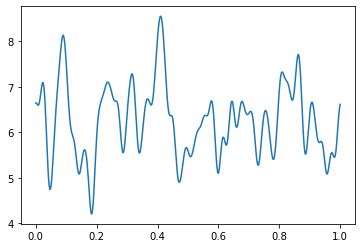

In [104]:
i = 10; L=5; B=1
phi[i-5:i+5]

def convolve1D(ar):
    convolved = np.zeros(len(ar))
    ar2 = np.concatenate([phi, phi]) # double array to prevent overflow indexing
    for i in range(len(ar)):
        convolved[i] = sum([np.exp(-(i-k)**2/(2*L**2))*ar2[k] for k in range(i-5*L, i+5*L)])
    return convolved
phi_conv = convolve1D(phi)

# define ramp-up function
def ramp(t):
    if t<5:
        return t*2
    else:
        return 10
rampv = np.vectorize(ramp)

def Kappa(p):
    return (1-p)**3/p**2
Kappav = np.vectorize(Kappa)

def grad_p(x, t,w=1):
    return -(1-x)*ramp(t)*w/Kappa(x)

def d_phi_dt(phi, t):
    deriv = np.zeros(len(phi))
    for i, x in enumerate(phi):
        p = grad_p(x, t)
        if p**2 < B**2/L**2:
            deriv[i] = 0
        else:
            deriv[i] = -np.abs(x*(p**2 -B**2/L**2))
    return deriv

from scipy.integrate import odeint

steps = odeint(d_phi_dt, phi_conv, np.linspace(0,6, 1000))
print(steps)

plt.plot(np.linspace(0, 1, len(phi)), convolve1D(phi))

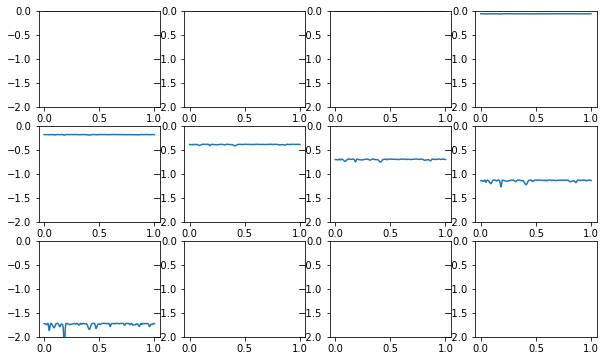

In [120]:
fig, ax = plt.subplots(3,4, figsize=(10,6))
axs = ax.ravel()
for i, ax in enumerate(axs):
    ax.plot(np.linspace(0,1,500), steps[i*10]-phi_conv)
    ax.set_ylim(-2,0)
#plt.plot(np.linspace(0, 1, 500), phi_conv)

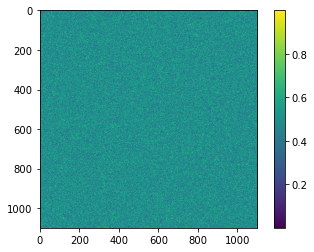

In [142]:
eps = 0.05
res=1000
dim = int(np.ceil(res*(1+2*eps)))
phi = np.random.rand(dim,dim)
plt.imshow(phi)
plt.colorbar()

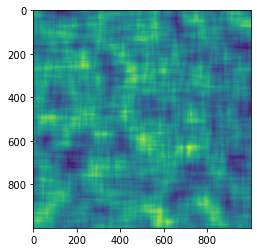

In [179]:
def w_matrix(eps, res):
    eps_res = 2*int(eps*res)
    weight_matrix = np.zeros((eps_res, eps_res))
    i, j = np.floor(weight_matrix.shape[0])/2, np.floor(weight_matrix.shape[0])/2
    for k in range(weight_matrix.shape[0]):
        for l in range(weight_matrix.shape[1]):
            weight_matrix[k,l] = np.exp(- (((i-k)/res)**2+((j-l)/res)**2) /(2*np.pi*eps**2))
    return weight_matrix
weight_matrix = w_matrix(eps, res)


def convolve_point(i,j, eps=eps, res = res):
    eps_res = int(eps*res)
    communication_area =  phi[i-eps_res:i+eps_res, j-eps_res: j+eps_res]
    weight_matrix = np.zeros(communication_area.shape)
    i_new_index, j_new_index = np.floor(communication_area.shape[0]/2), np.floor(communication_area.shape[0]/2)
    for k in range(weight_matrix.shape[0]):
        for l in range(weight_matrix.shape[1]):
            weight_matrix[k,l] = np.exp(- (((i_new_index-k)/res)**2+((j_new_index-l)/res)**2) /(2*np.pi*eps**2))
    
    return np.sum(np.multiply(communication_area, weight_matrix))/(eps_res*2+1)**2

# plt.imshow(convolve_point(100,100))
# plt.colorbar()

convolve_point(100,100)
eps_res = int(eps*res)
smoothed = np.zeros((res, res))
for i in range(eps_res, smoothed.shape[0]+eps_res):
    for j in range(eps_res,smoothed.shape[0]+eps_res):
        communication_area = phi[i-eps_res:i+eps_res, j-eps_res: j+eps_res]
        smoothed[i-eps_res,j-eps_res] = np.sum(np.multiply(communication_area, weight_matrix))/(eps_res*2+1)**2

plt.imshow(smoothed)


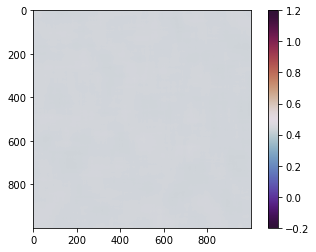

In [188]:
from matplotlib import cm 
cmap = cm.get_cmap("twilight_shifted")
plt.imshow(smoothed, cmap=cmap, vmin=-0.2, vmax = 1.2)
plt.colorbar()

In [189]:
np.savetxt("data/initial_conditions.txt", smoothed)

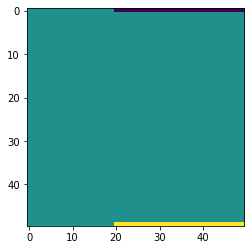

In [218]:

from utils import *

plt.imshow(fluid_forcing(np.zeros((50,50)).shape, 0.05, 1, 30, 20))
    

In [220]:
update_rule_test = dphi_FOFD(smoothed, np.ones((1001,1001)), dt=0.05)

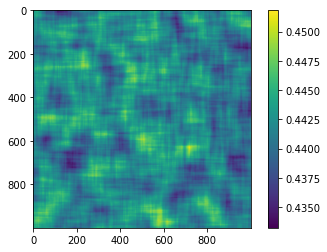

In [216]:
plt.imshow(update_rule_test)
plt.colorbar()

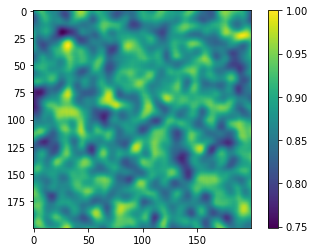

In [248]:
import numpy as np
from numpy import exp
from math import pi
import matplotlib.pyplot as plt
from random import seed

seed(205) # set seed 
# define constants and initialize grid
eps = 0.05
res=200
dim = int(np.ceil(res*(1+2*eps)))
phi = np.random.rand(dim,dim)


def w_matrix(eps, res):
    """Defines exponential decay matrix based on grid resolution (res) and communication length eps"""
    eps_res = 2*int(eps*res) # eps on each side
    weight_matrix = np.zeros((eps_res, eps_res))
    i, j = np.floor(weight_matrix.shape[0])/2, np.floor(weight_matrix.shape[0])/2 # index of middle gridpoint
    # iterate through gridpoints to determine weighting by distance
    for k in range(weight_matrix.shape[0]):
        for l in range(weight_matrix.shape[1]):
            # division (can be adjusted) gives scale of how fast weighting decreases
            weight_matrix[k,l] = np.exp(- (((i-k)/res)**2+((j-l)/res)**2) /(eps**2/pi)) 
    return weight_matrix
weight_matrix = w_matrix(eps, res)

def convolve_matrix(phi, eps, res):
    """Smoothing function: applies weight matrix to all gridpoints in phi matrix"""
    eps_res = int(eps*res)
    smoothed = np.zeros((res, res))
    for i in range(eps_res, smoothed.shape[0]+eps_res):
        for j in range(eps_res,smoothed.shape[0]+eps_res):
            # index out communication area
            communication_area = phi[i-eps_res:i+eps_res, j-eps_res: j+eps_res]
            # elementwise sum of weights and communication points
            smoothed[i-eps_res,j-eps_res] = np.sum(np.multiply(communication_area, weight_matrix))/((eps_res*2+1))**2
    
    return smoothed/(np.max(smoothed))

smoothed = convolve_matrix(phi, eps, res)
plt.imshow(smoothed)
plt.colorbar()